<a href="https://colab.research.google.com/github/antsh3k/NN-learning/blob/master/4_Agressive_Tweets_Classification_Simple_ANN_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


Before doing anything **Switch to GPU**


---




# Prepare your environment 

In [0]:
# IMPORTS (try to organize/group your imports)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import json
import spacy
from os import path

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, \
                            recall_score

In [0]:
# Any global variables
SEED = 15
DATA_PATH = '/content/'
MAX_SEQ_LEN = 40  # this is to standardise the dataset
nlp = spacy.load('en')
DEVICE = 'cuda'

In [0]:
# Set SEEDs - Very important - without this no one will ever be able 
#to reproduce the results you got.
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Examine and Prepare the Data


## In deep learning it is not very often that we load the whole dataset into memory, especially the text portion of datasets.

We want to keep our data/text on the disk and load only what is necessary. Normally we create an iterator that reads the sentences one by one.

In [0]:
# Download the data and save into raw_data.txt
import requests
url = "https://raw.githubusercontent.com/w-is-h/DeepLearningNLP-Medical/master/Session_5/data/tweets.json"
response = requests.get(url, stream=True)

# Save the dataset into a file
f_raw_data = open(path.join(DATA_PATH, 'raw_data.txt'), 'wb')
f_raw_data.write(response.content)
f_raw_data.close()

In [0]:
# To checkout files we now use bash commands
!head /content/raw_data.txt

{"content": "Get fucking real dude.","annotation":{"notes":"","label":["1"]},"extras":null,"metadata":{"first_done_at":1527503426000,"last_updated_at":1527503426000,"sec_taken":0,"last_updated_by":"jI67aE5hwwdh6l16bcfFVnpyREd2","status":"done","evaluation":"NONE"}}
{"content": "She is as dirty as they come  and that crook Rengel  the Dems are so fucking corrupt it's a joke. Make Republicans look like  ...","annotation":{"notes":"","label":["1"]},"extras":null,"metadata":{"first_done_at":1527503426000,"last_updated_at":1527503426000,"sec_taken":0,"last_updated_by":"jI67aE5hwwdh6l16bcfFVnpyREd2","status":"done","evaluation":"NONE"}}
{"content": "why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.","annotation":{"notes":"","label":["1"]},"extras":null,"metadata":{"first_done_at":1527503426000,"last_updated_at":1527503426000,"sec_taken":0,"last_updated_by":"jI67aE5hwwdh6l16bcfFVnpyREd2","status":"done","evaluatio

In [0]:
f_x_raw = open(path.join(DATA_PATH, 'x_raw.txt'), 'w')
# We load labels because they are small
y = []


for line in open(path.join(DATA_PATH, 'raw_data.txt'), 'rb'):
  # Each line is in fact a json document
  doc = json.loads(line) 

  # TODO: Write text to the file and append labels to 'y',
  #each row must contain the text of one tweet. Each line in the f_x_raw
  #must contain one tweet
  text = doc['content']
  f_x_raw.write("{}\n".format(text)) #?
  
  label = int(doc["annotation"]['label'][0])
  y.append(label) #? append the label for this doc/tweet

# Close the file
f_x_raw.close()

# This is a typical way to add sanity checks to your code, can be very helpful.
assert type(y[0]) == int

In [0]:
!head /content/x_raw.txt # use this bash command to visualise any errors in your code. Is this the right file etc? double checking for errors at each step is good practise

Get fucking real dude.
She is as dirty as they come  and that crook Rengel  the Dems are so fucking corrupt it's a joke. Make Republicans look like  ...
why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.
Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense.
WTF are you talking about Men? No men thats not a menage  that's just gay.
Ill save you the trouble sister. Here comes a big ol fuck France block coming your way here on the twitter.
Im dead serious.Real athletes never cheat don't even have the appearance of at his level. Fuck him dude seriously  I think he did
...go absolutely insane.hate to be the bearer of bad news..LoL..dont shoot the messenger (cause we all know you bought that pistol
Lmao  im watching the same thing ahaha. The gay guy is hilarious! "Dede having a good day and I dont want anyone to mess it up."
LOL  no he said  W

### Before cleaning we should analyse the dataset and understand what to remove or keep, but I've already done that so we skip it.

In [0]:
# TODO: Cleaning
# Every time a character (excluding numbers) is repeated more than 2 times, 
# reduce to 2 - e.g. "0000 yesssssssss!!!!!!" -> "0000 yess!!"
def clean_text(text):
  clean_text = re.sub(r'([^0-9]{1})\1{2,}', r'\1\1', text) #the one without triplets
  return clean_text

In [0]:
# Test the clean_text function
test_text = "0000 yesssssss!!!!!!"
test_out = clean_text(test_text)
print(test_out)

real_out = "0000 yess!!"
assert real_out == test_out

0000 yess!!


# Download Word Embeddings

It is very rare to train your own embeddings, if your domain is not exteremly specific. Usually we use pretrained embeddings.

In this case we are going to use embeddings from GloVe: Global Vectors for Word Representation. They have pretrained vectors for twitter datasets. 


**NOTE:**

The downside of doing this is that we can't continue the trainig of the vectors unless they are in the gensim word2vec format. 




---


More info at: https://nlp.stanford.edu/projects/glove/

In [0]:
# JUPYTER/COLAB ONLY!!!
# Download the data
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip  # downloads the file
!unzip glove*.zip   # unzips the file

--2019-09-10 14:49:48--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-09-10 14:49:48--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2019-09-10 14:49:49--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [0]:
# Load the vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Convert glove file to word2vec format
glove_file = datapath('/content/glove.twitter.27B.200d.txt')
tmp_file = get_tmpfile("tmp_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)

# Load the newly generated file
model = KeyedVectors.load_word2vec_format(tmp_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


KeyboardInterrupt: ignored

In [0]:
# Sanity - Check similarity 
model.most_similar("house") # TODO: print words most similar to the word "house"

""" 
model["house"] # this is the vector representation of the house
list(model.wv.vocab.keys()) # this loads all the words
len list(model.wv.vocab.keys()) # this load the len of all words
"""


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


' \nmodel["house"] # this is the vector representation of the house\nlist(model.wv.vocab.keys()) # this loads all the words\nlen list(model.wv.vocab.keys()) # this load the len of all words\n'

In [0]:
embeddings = [] # A list of embeddings for each word in the word2vec vocab

# Embeddings is a list, meaning we know that embeddings[1] is a vector for the 
#word with ID=1, but we don't know what word is that. That is why we need 
#the id2word and word2id mappings.
id2word = {}
word2id = {}

# TODO: Loop over all words in the vocabulary and add the values
for word in model.vocab.keys():
  id = len(embeddings) #? What is the position of this word in the embeddings list?
  id2word[id] = word # Add mapping from ID to word
  word2id[word] = id # From word 2 id
  embeddings.append(model[word]) # Add the embedding for 'word', embeddings are available in the 'model'

# Add <UNK> (unknown tokens) and <PAD> (padding to help everything to have the same length)
word = "<UNK>"
id2word[len(embeddings)] = word
word2id[word] = len(embeddings)
embeddings.append(np.random.rand(len(embeddings[0])))

# TODO - Add the word '<PAD>' and set the embedding to all zeros
word = "<PAD>"
id2word[len(embeddings)] = word
word2id[word] = len(embeddings)
embeddings.append(np.zeros(len(embeddings[0])))

# TODO: Convert the embeddings list into a tensor of type float32
embeddings = torch.tensor(embeddings, dtype= torch.float32) #?

# Sanity
assert len(embeddings) == len(id2word) == len(word2id)
assert model['house'][0] == embeddings[word2id['house']][0] # if these embeddings are not the same there will be an assertion error

# Convert words to integers

Usually we don't want to keep our input in the string format, it is very time/memory costly to load text all the time. We want to convert text into integers. That is why we have our mapping `word2id`


Example:
```
our_vocab = ['i', 'house', 'was', 'test', '<UNK>', '<PAD>']
text = "I was running."
tkns = ['i', 'was', 'running']
ind_tkns = [0, 2, 4] 
```

#### Remember we have a word2id mapping that you can use to go from tokens to inds.

In [0]:
x_ind = []
for text in open(path.join(DATA_PATH, 'x_raw.txt')):
  # TODO: clean text
  text = clean_text(text) #?
  # Covnert text to lowercased tokens, skip punct and white-space
  tkns = [tkn.lower_ for tkn in nlp.tokenizer(text) if not tkn.is_punct and len(tkn.lower_.strip()) >0] #?
  # Convert each token into its id, take care that words not in the vocabulary
  #should have the ID of the '<UNK>' token at that place. 
  ind_tkns = [word2id[tkn] if tkn in word2id else word2id['<UNK>'] for tkn in tkns] #?
  # Append to x_ind
  x_ind.append(ind_tkns)


In [0]:
print(x_ind[1])

[147, 32, 124, 2567, 124, 109, 243, 26, 45, 80773, 1193514, 13, 25700, 70, 55, 408, 22480, 33, 41, 11, 1697, 183, 15927, 273, 63]


#### When needed we can easily go back to words for an input sentence using the id2word mapping.

In [0]:
# TODO: convert the indices for x_ind[1] back to words
print(" ".join([id2word[id] for id in x_ind[1]])) #?

she is as dirty as they come and that crook <UNK> the dems are so fucking corrupt it 's a joke make republicans look like


# Analyse the dataset

(array([12179.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7822.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

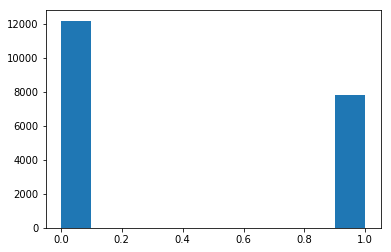

In [0]:
### visualise the data first

plt.hist(y) 

In [0]:
# TODO: For each tweet calculate its length and add to tweet_lengths, plus 
#calculate all the statistics
tweet_lengths = [len(tweet) for tweet in x_ind] #? Array of tweet lengths
pos = np.sum(y) # Number of positive examples
neg = len(y) - pos # Number of negative examples 
avg = np.mean(tweet_lengths) # Average tweet length
md = np.median(tweet_lengths)# Median tweet length
mx = np.max(tweet_lengths)# Maximum tweet length
mi = np.min(tweet_lengths) # Minimum tweet length

print("Number of positive examples: {}".format(pos))
print("Number of negative examples: {}".format(neg))
print("Average length of the tweets: {}".format(avg))
print("Median length of the tweets: {}".format(md))
print("Max length of the tweets: {}".format(mx))
print("Min length of the tweets: {}".format(mi))

prim_tweet_lens = np.array([ln if ln > 0 else 1 for ln in tweet_lengths])

Number of positive examples: 7822
Number of negative examples: 12179
Average length of the tweets: 13.369781510924454
Median length of the tweets: 12.0
Max length of the tweets: 363
Min length of the tweets: 0


# Prepare the dataset

We want all the tweets to have the same length. 



---


MAX_SEQ_LEN = 4

Examples:
```
pad_ind = word2id['<PAD>']

tweet_1 = [1, 32]
# Becomes
tweet_1 = [1, 32, pad_ind, pad_ind]

tweet_2 = [1, 2, 32, 32, 43, 45]
# Becomes
tweet_2 = [1, 2, 32, 32]

```

In [0]:
# Pad everything to the same length, or remove the extra words
x_ind_pad = []
for i in range(len(x_ind)):
  tweet = x_ind[i]
  # Get the pad ID
  pad_id = word2id['<PAD>'] #?
  
  # Remove extra words or add the ID for <PAD> if < MAX_SEQ_LEN
  if len(tweet) < MAX_SEQ_LEN:
    tweet.extend([pad_id] * (MAX_SEQ_LEN - len(tweet)))#?
  elif len(tweet) > MAX_SEQ_LEN:
    tweet = tweet[0:MAX_SEQ_LEN]#?
  x_ind_pad.append(tweet)


In [0]:
tweet_lengths = [len(tweet) for tweet in x_ind_pad]
# TODO: Print again the stats from above

pos = np.sum(y) # Number of positive examples
neg = len(y) - pos # Number of negative examples 
avg = np.mean(tweet_lengths) # Average tweet length
md = np.median(tweet_lengths)# Median tweet length
mx = np.max(tweet_lengths)# Maximum tweet length
mi = np.min(tweet_lengths) # Minimum tweet length

print("Number of positive examples: {}".format(pos))
print("Number of negative examples: {}".format(neg))
print("Average length of the tweets: {}".format(avg))
print("Median length of the tweets: {}".format(md))
print("Max length of the tweets: {}".format(mx))
print("Min length of the tweets: {}".format(mi))

Number of positive examples: 7822
Number of negative examples: 12179
Average length of the tweets: 40.0
Median length of the tweets: 40.0
Max length of the tweets: 40
Min length of the tweets: 40


In [0]:
# Split into train/test and move to pytorch 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, l_train, l_test = train_test_split(x_ind_pad, y, prim_tweet_lens, test_size=0.2, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
l_train = torch.tensor(l_train, dtype=torch.float32).reshape(-1, 1)

# TODO: do the same for the test 
x_test = torch.tensor(x_test, dtype=torch.long) #?
y_test = torch.tensor(y_test, dtype=torch.long) #?
l_test = torch.tensor(l_test, dtype=torch.float32).reshape(-1, 1) #?

# Build the network

In [0]:
class Net(nn.Module):
  def __init__(self, embeddings):
    super(Net, self).__init__()
    # Get the required sizes
    vocab_size = len(embeddings)
    embedding_size = len(embeddings[0])
    # Initialize embeddings
    self.embeddings = nn.Embedding(vocab_size, embedding_size)
    self.embeddings.load_state_dict({'weight': embeddings})
    
    # Disable training for the embeddings - IMPORTANT
    self.embeddings.weight.requires_grad = False

    # TODO add three layers, 
    # 1) 200 neurons 
    # 2) 50 neurons 
    # 3) 2 neurons
    self.fc1 = nn.Linear(embedding_size, 200,) #?
    self.fc2 = nn.Linear(200, 50) #?
    self.fc3 = nn.Linear(50, 2) #?

    # TODO: create one dropout layer with p=0.5
    self.d1 = nn.Dropout(0.5)#?

  def forward(self, x, lns):
    # Embed the input: from id -> vec
    x = self.embeddings(x)
    
    # We did not average the words per sentence until now, we'll
    #do it here
    x = torch.sum(x, dim=1) 
    x = x / lns

    # TODO: run 'x' through the layers, add dropout to the first and second
    x = self.d1(torch.relu(self.fc1(x))) #? relu activation + dropout
    x = self.d1(torch.relu(self.fc2(x))) #? relu activation + dropout
    x = torch.sigmoid(self.fc3(x)) #? sigmoid activation NO dropout
    return x

In [0]:
#Device
device = torch.device(DEVICE)
# Create the network
net = Net(embeddings)
criterion = nn.CrossEntropyLoss()
# Make a SGD optimizer with lr=0.002 and momentum=0.99
parameters = filter(lambda p: p.requires_grad, net.parameters())
print(parameters)
optimizer = optim.SGD(parameters, lr=0.01, momentum=0.99)
# Move the net to the device
net.to(device)

Net(
  (embeddings): Embedding(1193516, 200)
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
  (d1): Dropout(p=0.5)
)

# Train

In [0]:
device = torch.device(DEVICE)
# Move data to the right device only test, train is in batches
x_test = x_test.to(device)
y_test = y_test.to(device)
l_test = l_test.to(device)

losses = []
accs = []
accs_dev = []

batch_size = 1000

# TODO: calculate the number of batches given training size len(x_train)
num_batches = int(len(x_train / batch_size)) #?
for epoch in range(200):
  # TODO: Switch network to train mode
  net.train()

  # Create the running loss array
  running_loss = []
  for i in range(num_batches):
    start = i * batch_size
    end = (i+1) * batch_size
    
    # TODO: Get the batch
    x_train_batch = x_train[start:end] #?
    y_train_batch = y_train[start:end]#?  
    l_train_batch = l_train[start:end]#? 

    # TODO: Move the batches to the right device
    x_train_batch = x_train_batch.to(device) #?
    y_train_batch = y_train_batch.to(device) #?
    l_train_batch = l_train_batch.to(device) #?

    # TODO: zero gradients
    optimizer.zero_grad() #?
    # Get outputs for our batch
    outputs = net(x_train_batch, l_train_batch) #?
    # Get loss
    loss = criterion(outputs, y_train_batch) #?
    # Do the backward step
    loss.backward() #?
    # Do the optimizer step
    optimizer.step() #?

    # Add the loss to the running_loss
    running_loss.append(loss.item())

  if epoch % 5 == 0:
      net.eval()
      outputs = net(x_train_batch, l_train_batch)
      acc = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in torch.max(outputs, 1)[1].cpu().detach().numpy()], y_train_batch.cpu().numpy())

      outputs_dev = net(x_test, l_test)
      acc_dev = sklearn.metrics.accuracy_score(torch.max(outputs_dev, 1)[1].cpu().detach().numpy(), y_test.cpu().numpy())
      f1_dev = f1_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      p_dev = precision_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      r_dev = recall_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      
      print("Epoch: {:4} Loss: {:.5f} Acc: {:.3f} Acc Dev: {:.3f} F1 Dev: {:.3f} p Dev: {:.3f} r Dev: {:.3f}".format(epoch, np.average(running_loss), acc, acc_dev, f1_dev, p_dev, r_dev))
      
print('Finished Training')

# ConvNets

In pytorch a convolutional layer is defined as:
```
nn.Conv2d(<number of input chanels>, <number of filters>, kernel_size)
```
$\text{number of input chanels}$ - The depth, in our case always 1

$\text{kernel_size}$ - is a touple setting the **height** $x$ **width** of a kernel. In our case the kernel will be of size (n, embedding_size) where 'n' is the number of words or pattern length. 


### We are going to create three independent conv blocks, stack the output and add a fc layer onto that.

In [0]:
class Net(nn.Module):
  def __init__(self, embeddings):
    super(Net, self).__init__()
    # TODO: Get the required sizes
    vocab_size = #?
    embedding_size = #?

    # Initialize embeddings
    self.embeddings = nn.Embedding(vocab_size, embedding_size)
    # TODO: Load the pretrained weights
    self.embeddings.#?

    # TODO: Disable training for embeddings
    #?

    # Set the number of filters
    n_filters = 128
    # Create 3 different kernel sizes
    k1 = #?
    k2 = #?
    k3 = #?

    # TODO: Create three conv layers
    self.conv1 = #?
    self.conv2 = #?
    self.conv3 = #?

    # The fully connected
    self.fc1 = nn.Linear(3 * n_filters, 2)
    # Add some dropout as always
    self.d1 = nn.Dropout(0.5)

  def conv_block(self, input, conv):
    out = conv(input)
    out = F.relu(out.squeeze(3))
    out = F.max_pool1d(out, out.size()[2]).squeeze(2)
    return out

  def forward(self, x, lns=0):
    # Embed the input: from id -> vec
    x = self.embeddings(x) # x.shape = batch_size x sequence_length x emb_size
    
    # Add a dimension at '1'
    x = x.unsqueeze(1) # Because the expected shape = batch_size x channels x sequence_length x emb_size
    
    # Get the three outputs from conv layers
    x1 = self.conv_block(x, self.conv1)
    x2 = #? add conv2, all for x as input
    x3 = #? add conv3, all for x as input

    x_all = torch.cat((x1, x2, x3), 1)
    x_all = self.d1(x_all)
    logits = self.fc1(x_all)

    return logits

In [0]:
#Device
device = torch.device(DEVICE)
# Create the network and get CE loss
net = Net(embeddings)
criterion = nn.CrossEntropyLoss()
# We don't want parameters that don't require a grad in the optimizer
parameters = filter(lambda p: p.requires_grad, net.parameters())
print(parameters)
#TODO: Switch optimizer to Adam and set lr=0.001
optimizer = optim.Adam(parameters, lr=0.001)
# Move the net to the device
net.to(device)

In [0]:
device = torch.device(DEVICE)
# Move data to the right device only test, train is in batches
x_test = x_test.to(device)
y_test = y_test.to(device)

losses = []
accs = []
accs_dev = []

batch_size = 1000

num_batches = int(np.ceil(len(x_train) / batch_size))
for epoch in range(200):
  net.train()

  # Create the running loss array
  running_loss = []
  for i in range(num_batches):
    start = i * batch_size
    end = (i+1) * batch_size
    
    x_train_batch = x_train[start:end] 
    y_train_batch = y_train[start:end] 
    l_train_batch = l_train[start:end]

    # TODO: Move the batches to the right device
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)
    l_train_batch = l_train_batch.to(device)

    optimizer.zero_grad()
    outputs = net(x_train_batch, l_train_batch)
    loss = criterion(outputs, y_train_batch)
    loss.backward()
    optimizer.step()

    # Add the loss to the running_loss
    running_loss.append(loss.item())

  if epoch % 5 == 0:
      net.eval()
      outputs = net(x_train_batch, l_train_batch)
      acc = sklearn.metrics.accuracy_score([1 if x > 0.5 else 0 for x in torch.max(outputs, 1)[1].cpu().detach().numpy()], y_train_batch.cpu().numpy())

      outputs_dev = net(x_test, l_test)
      acc_dev = sklearn.metrics.accuracy_score(torch.max(outputs_dev, 1)[1].cpu().detach().numpy(), y_test.cpu().numpy())
      f1_dev = f1_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      p_dev = precision_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      r_dev = recall_score(y_test.cpu().numpy(), torch.max(outputs_dev, 1)[1].cpu().detach().numpy())
      
      print("Epoch: {:4} Loss: {:.5f} Acc: {:.3f} Acc Dev: {:.3f} F1 Dev: {:.3f} p Dev: {:.3f} r Dev: {:.3f}".format(epoch, np.average(running_loss), acc, acc_dev, f1_dev, p_dev, r_dev))
      
print('Finished Training')

In [0]:
# TODO: Write a tweet
tweet = "<your tweet>"
print(tweet)

In [0]:
tkns = # Clean the tokens in the same way you've done earlier
print(tkns)

In [0]:
# Convert tokens to indices 
inds = #?
print(inds)

In [0]:
# Add padding to match len(inds) == 40
inds.extend([word2id['<PAD>']] * (MAX_SEQ_LEN - len(inds)))
print(inds)

In [0]:
# Move to torch
inds = torch.tensor([inds]).to(device)
print(inds)

In [0]:
# TODO: Predict
net #? switch to eval mode
out = #? 
out = #? Calculate softmax on the output torch.softmax - don't forget the dimension
print(out)

# Find where mistakes are made in the test set 

In [0]:
# TODO: Get all predictions for x_test and apply softmax
out = #?

In [0]:
# Find a couple of examples where the Net is sure it is correct
out = out.detach().cpu().numpy()
for i in range(200):
  pred = np.argmax(out[i])
  if pred != y_test[i] and out[i][pred] > 0.9:
    print(i)

In [0]:
# Print the examples
ind = 105
print(y_test[ind])
print(out[ind])
print(" ".join([id2word[i] for i in x_test[ind].cpu().detach().numpy() if id2word[i] != '<PAD>']))